In [1]:
# imports
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as smt_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix
from sklearn import set_config

In [2]:
# general settings
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [3]:
# load data
df_features = pd.read_csv("data/pumps_values.csv")
df_target = pd.read_csv("data/pumps_labels.csv")

# EDA & Data Cleaning

In [4]:
print(df_features.shape)
df_features.head()

(59400, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df_features.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [6]:
print(df_target.shape)
df_target.head()

(59400, 2)


,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [7]:
df_pumps = df_features.merge(df_target, on="id")

"id", "recorded_by" and "funder" columns were dropped because they dont represent a useful information.

In [8]:
# check duplicates
df_pumps.duplicated().sum()

0

In [9]:
# replace missing values that are not in nan format by nan
df_pumps.replace(["unknown","None"],np.nan,inplace=True)

In [10]:
# normalized numbers of missing values
sr_nan = (df_pumps.isna().sum())/df_pumps.shape[0]
sr_nan[sr_nan!=0]

funder               0.061229
installer            0.061549
wpt_name             0.000034
subvillage           0.006246
public_meeting       0.056128
scheme_management    0.065286
scheme_name          0.485017
permit               0.051448
management           0.009444
management_group     0.009444
payment              0.137323
payment_type         0.137323
water_quality        0.031582
quality_group        0.031582
quantity             0.013283
quantity_group       0.013283
source               0.001111
source_class         0.004680
dtype: float64

In [11]:
# drop unecessary columns
df_pumps.drop(columns=["id", "recorded_by", "funder"], inplace=True)

In [12]:
def replace_nan_id(df, id, column):
    index = df.index
    values = df.groupby(id).first()[column]
    values_dict = values.to_dict()
    df_reindexed = df.set_index(id)
    df_addressed = df_reindexed[column].fillna(values_dict).reset_index()
    return df_addressed.reindex(index)[column]

In [13]:
# replace missing values depending on the ids
sr_nan = (df_pumps.isna().sum())
for c in sr_nan[sr_nan != 0].index:
  if c != "wpt_name":
    df_pumps[c] = replace_nan_id(df_pumps,"wpt_name",c)

In [14]:
# display normalized number of missing values after replacement
sr_nan = (df_pumps.isna().sum())/df_pumps.shape[0]
sr_nan[sr_nan!=0]

installer            0.039579
wpt_name             0.000034
subvillage           0.002896
public_meeting       0.034646
scheme_management    0.039848
scheme_name          0.334007
permit               0.033165
management           0.005219
management_group     0.005219
payment              0.084562
payment_type         0.084562
water_quality        0.016246
quality_group        0.016246
quantity             0.007205
quantity_group       0.007205
source               0.000572
source_class         0.002761
dtype: float64

In [15]:
# change types
cols_to_str = ["construction_year", "num_private", "region_code", "district_code"]
df_pumps[cols_to_str] = df_pumps[cols_to_str].astype(str)
cols_to_float = df_pumps.select_dtypes("int").columns
df_pumps[cols_to_float] = df_pumps[cols_to_float].astype(float)

In [16]:
# check for inconsistencies in classes
cat_cols = df_pumps.select_dtypes("object").columns.delete(0)
for c in cat_cols :
  print(f"* {c}: {df_pumps[c].unique()}")

* installer: ['Roman' 'GRUMETI' 'World vision' ... 'Dina' 'brown' 'SELEPTA']
* wpt_name: ['none' 'Zahanati' 'Kwa Mahundi' ... 'Kwa Yahona Kuvala' 'Mshoro'
 'Kwa Mzee Lugawa']
* num_private: ['0' '39' '5' '45' '6' '3' '698' '32' '15' '7' '25' '102' '1' '93' '14'
 '34' '120' '17' '213' '47' '8' '41' '80' '141' '20' '35' '131' '4' '22'
 '11' '87' '61' '65' '136' '2' '180' '38' '62' '9' '16' '23' '42' '24'
 '12' '668' '672' '58' '150' '280' '160' '50' '1776' '30' '27' '10' '94'
 '26' '450' '240' '755' '60' '111' '300' '55' '1402']
* basin: ['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
* subvillage: ['Mnyusi B' 'Nyamara' 'Majengo' ... 'Itete B' 'Maore Kati' 'Kikatanyemba']
* region: ['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']
* region_code: ['11' 

In [17]:
# change values other than 0 to 1 for num_private feature
df_pumps["num_private"] = df_pumps["num_private"].apply(lambda x : "0" if  x == "0" else "1")

In [18]:
# categorical features cardinalities
cat_cols = df_pumps.select_dtypes("object").columns.delete(0)
for e in cat_cols :
  print(f"{e}: {len(df_pumps[e].unique())}")

installer: 2145
wpt_name: 37400
num_private: 2
basin: 9
subvillage: 19288
region: 21
region_code: 27
district_code: 20
lga: 125
ward: 2092
public_meeting: 3
scheme_management: 12
scheme_name: 2696
permit: 3
construction_year: 55
extraction_type: 18
extraction_type_group: 13
extraction_type_class: 7
management: 12
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6
status_group: 3


In [19]:
for c in cat_cols:
  print(f"* {c}:\n{df_pumps[c].value_counts(dropna=False)}\n")

* installer:
DWE              17775
None              2351
Government        1905
RWE               1236
Commu             1079
                 ...  
CCP                  1
Tasaf and Lga        1
WA                   1
Insititutiona        1
SELEPTA              1
Name: installer, Length: 2145, dtype: int64

* wpt_name:
none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: wpt_name, Length: 37400, dtype: int64

* num_private:
0    58643
1      757
Name: num_private, dtype: int64

* basin:
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lak

In [20]:
# check identical values in two columns
def   check_identical_columns(data,c1,c2,include_na=False) :
          data.reset_index(drop=True,inplace=True)
          data = data.astype(str).apply(lambda x: x.str.lower())
          n = data.shape[0]
          j = 0
          for i in range(n):
            if data.loc[i,c1] == data.loc[i,c2] :
                j += 1
            if include_na :
                if np.isnan(data.loc[i,c1]) | np.isnan(data.loc[i,c2]) :
                  j += 1
          return j/n

In [21]:
# check columns that seem to present same information
print("extraction_type / extraction_type_group :",check_identical_columns(df_pumps,"extraction_type","extraction_type_group"))
print("extraction_type / extraction_type_class :",check_identical_columns(df_pumps,"extraction_type","extraction_type_class"))
print("payment / payment_type :",check_identical_columns(df_pumps,"payment","payment_type"))
print("water_quality / quality_group :",check_identical_columns(df_pumps,"water_quality","quality_group"))
print("quantity / quantity_group :",check_identical_columns(df_pumps,"quantity","quantity_group"))
print("source / source_type :",check_identical_columns(df_pumps,"source","source_type"))
print("waterpoint_type / waterpoint_type_group :",check_identical_columns(df_pumps,"waterpoint_type","waterpoint_type_group"))
print("scheme_management / management :",check_identical_columns(df_pumps,"scheme_management","management"))

extraction_type / extraction_type_group : 0.9584343434343434
extraction_type / extraction_type_class : 0.6392929292929292
payment / payment_type : 0.5598316498316498
water_quality / quality_group : 0.11646464646464647
quantity / quantity_group : 1.0
source / source_type : 0.623030303030303
waterpoint_type / waterpoint_type_group : 0.8972558922558923
scheme_management / management : 0.849915824915825


Except the "water_quality / quality_group" pair, columns in each these pairs represent almost the same information so we can the parent features.

In [22]:
# drop useless features
df_pumps.drop(columns=["extraction_type_group","extraction_type_class","payment_type","quantity_group","source_type","waterpoint_type_group","scheme_management"],inplace=True)

Text(0.5, 1.0, 'water_quality VS quality_group')

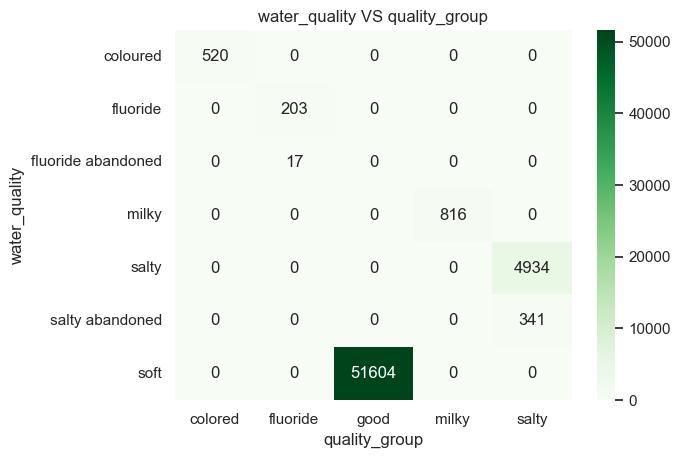

In [23]:
# display contingency matrix for "water_quality" and "quality_group" features
contingency_table = pd.crosstab(df_pumps['water_quality'], df_pumps['quality_group'])
sns.heatmap(contingency_table, fmt="d", annot=True, cmap="Greens")
plt.title("water_quality VS quality_group")

these two features represent almost the same information so we can drop the "quality group" column (it provide slightly less detailed information)

In [24]:
# drop "quality_group" feature
df_pumps.drop(columns="quality_group",inplace=True)

In [25]:
def combine_classes(data, features, treshold, rep_class, special_classes=[]):
  data[features] = data[features].replace(special_classes, rep_class)
  for cf in features:
      cardinal_classes = data[cf].value_counts()
      n_classes = len(data[cf].dropna().unique())
      if n_classes==1:
          data.drop(columns=cf, inplace=True)
          print(f'- "{cf}" feature was dropped, it is constant')
      class_to_rep = cardinal_classes[cardinal_classes<treshold].index
      n_class_to_rep = len(class_to_rep)
      if n_class_to_rep != 0:
          n = n_classes - n_class_to_rep
          if n==0 :
              data.drop(columns=cf, inplace=True)
              print(f'- "{cf}" feature was dropped, all classes are not representative')
          else:
              data[cf] = data[cf].replace(class_to_rep, rep_class)
              if (n==1) and (data[cf].value_counts()[rep_class] < treshold):
                  data.drop(columns=cf, inplace=True)
                  print(f'- "{cf}" feature was dropped, minority class is not representative')
              elif data[cf].value_counts()[rep_class] < treshold:
                  last_class_over_tresh = cardinal_classes[cardinal_classes>=treshold].index[-1]
                  data[cf] = data[cf].replace(last_class_over_tresh, rep_class)
                  print(f'- "{last_class_over_tresh}" class of the "{cf}" feature has been changed to "{rep_class}"')

In [26]:
# combine classes
cat_cols = df_pumps.select_dtypes("object").columns.delete([0, 14])
combine_classes(df_pumps, cat_cols, 1000, "other", ["Other"])

- "num_private" feature was dropped, minority class is not representative
- "subvillage" feature was dropped, all classes are not representative
- "Lindi" class of the "region" feature has been changed to "other"
- "ward" feature was dropped, all classes are not representative
- "parastatal" class of the "management_group" feature has been changed to "other"


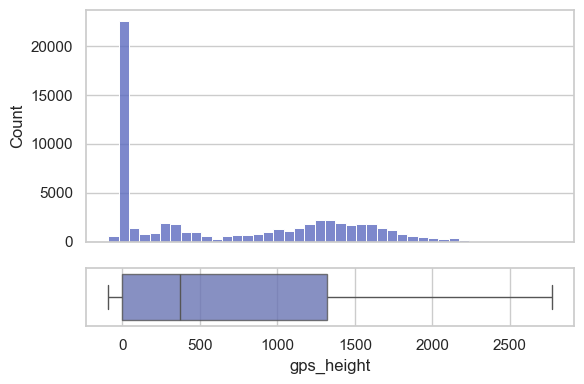

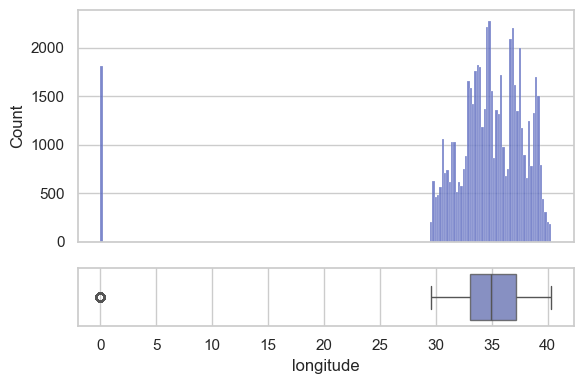

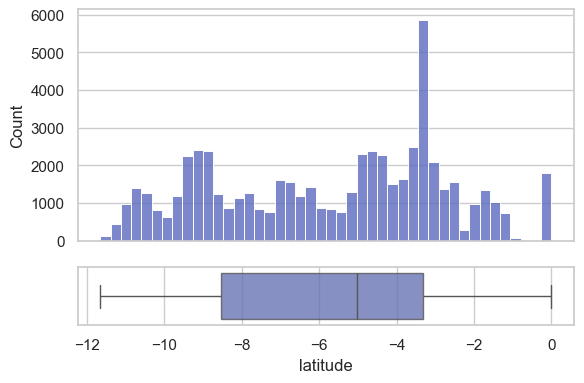

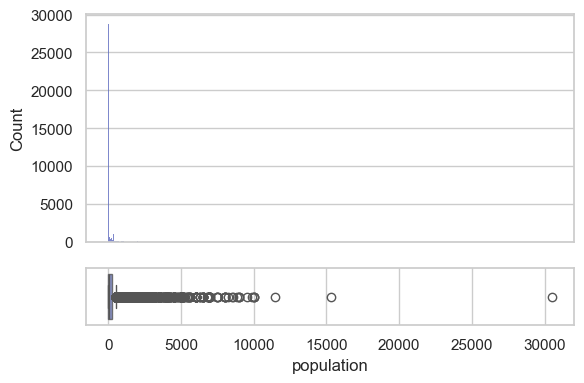

In [27]:
# histograms and boxplots of numerical variables
num_cols = df_pumps.select_dtypes("float").columns.delete(0)
for c in num_cols:
  gridspec = {'height_ratios':[0.8,0.2]}
  fig, axes = plt.subplots(nrows=2, figsize=(6,4),
                           sharex=True, gridspec_kw=gridspec)
  sns.histplot(data=df_pumps, x=c, color="#5C6BC0", alpha=0.8, ax=axes[0])
  sns.boxplot(data=df_pumps, x=c, color="#5C6BC0", boxprops=dict(alpha=0.8),
              ax=axes[1])
  axes[0].grid(axis="x")
  fig.tight_layout()
  plt.show()

Text(0.5, 1.0, 'Numerical Features Correlations')

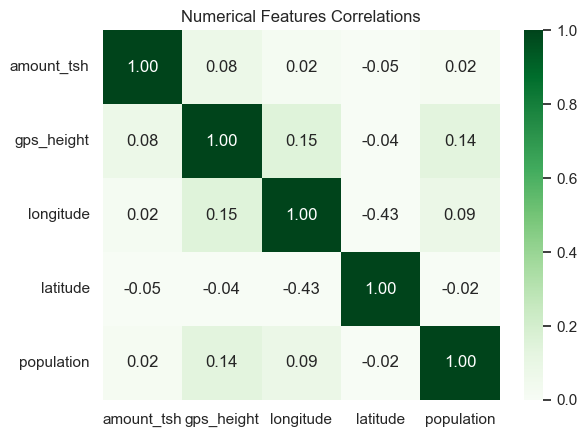

In [28]:
# numerical variables correlations
corr_matrix = df_pumps.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Greens", vmin=0, vmax=1)
plt.title("Numerical Features Correlations")

There is no correlation between each pair of numerical features

# Feature Engineering

In [29]:
df_pumps["construction_year"] = df_pumps["construction_year"].astype(float)
mean_year =  df_pumps["construction_year"][df_pumps["construction_year"]!=0].mean().round(0)
df_pumps["construction_year"].replace(0,mean_year,inplace=True)

In [30]:
# create a feature for operating time
df_pumps["record_year"] = pd.to_datetime(df_pumps.date_recorded).dt.year
df_pumps["operating_time"] = df_pumps["record_year"] - df_pumps["construction_year"].astype("float")
df_pumps.drop(columns=["date_recorded","record_year","construction_year"],inplace=True)

# Data Explanation

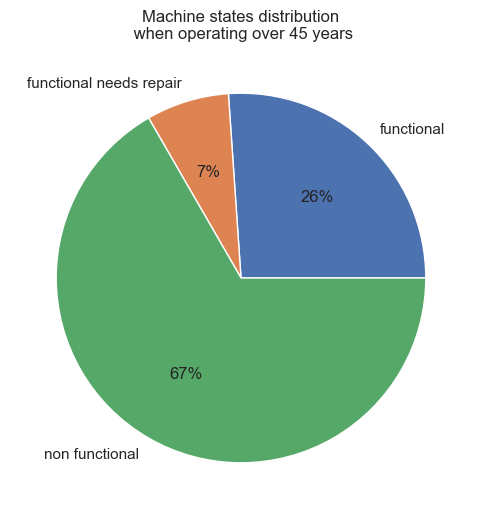

In [31]:
df_filtred_ot = df_pumps[df_pumps.operating_time>45]
df_filtred_ot["Number_of_states"] = 1
df_filtred_ot = df_filtred_ot.groupby("status_group",as_index=False).sum()
plt.figure(figsize=(6,6))
plt.pie(df_filtred_ot["Number_of_states"], labels=df_filtred_ot["status_group"], autopct='%.0f%%')
plt.title("Machine states distribution\n when operating over 45 years")
plt.show()

The magority of pumps states is non functional when the pump is oprating over 45 years so there is high risk of failure over this operating period.

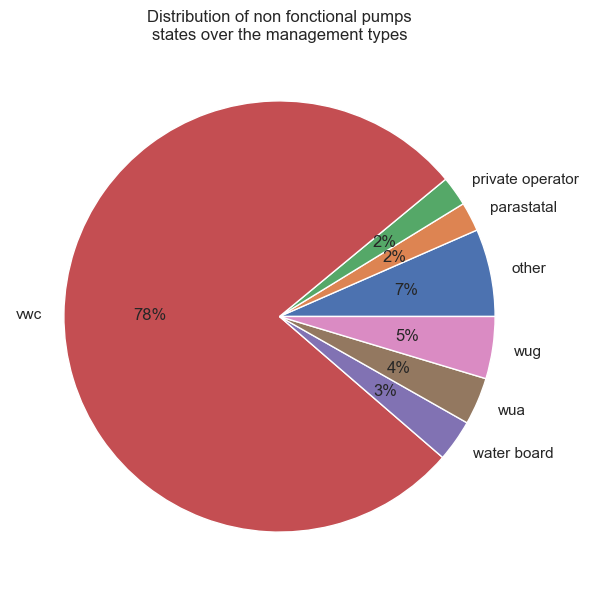

In [32]:
df_filtred_sg = (df_pumps[df_pumps.status_group=="non functional"]).dropna()
df_filtred_sg["Number_of_states"] = 1
df_filtred_sg = df_filtred_sg.groupby("management", as_index=False).sum()
plt.figure(figsize=(7,7))
plt.pie(df_filtred_sg["Number_of_states"], labels=df_filtred_sg["management"], autopct='%.0f%%')
plt.title("Distribution of non fonctional pumps\nstates over the management types")
plt.show()

The majority of non functional states are vwc managed. So it's most likely that there is a problem with this type of management.

# Modeling & Data Preprocessing

In [33]:
# define features and target
X = df_pumps.drop(columns="status_group")
y = df_pumps["status_group"]

In [34]:
# train-test split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=15, stratify=y)

In [35]:
dummy_cls = DummyClassifier(strategy="uniform")

In [36]:
# define different parameters for models
knn_params = dict(knn__n_neighbors=[2, 5, 20, 50, 100])
decision_tree_params = dict(decision_tree__max_depth=[None, 5, 50, 200],
                            decision_tree__min_samples_split=[2, 20, 50, 100])
random_forest_params = dict(random_forest__n_estimators=[5, 50, 100],
                            random_forest__max_depth=[None, 5, 50, 200],
                            random_forest__max_features=[1.0, 0.5])
adaboost_params = dict(adaboost__n_estimators= [50, 100],
                       adaboost__learning_rate=[1.0, 0.5])
xgboost_params = dict(xgboost__n_estimators= [100, 200, 400],
                                   xgboost__max_depth=[6,20, 100],
                                   xgboost__learning_rate= [0.3, 0.1])
stacking_classifier_params = dict(stacking_classifier__estimators = [[('rf', RandomForestClassifier()),
                                  ('svr',LinearSVC())],
                                   [('rf', RandomForestClassifier(n_estimators=50)),
                                  ('svr', LinearSVC())]])

In [37]:
models_dict = dict(knn=[KNeighborsClassifier(), knn_params],
                   decision_tree=[DecisionTreeClassifier(), decision_tree_params],
                   random_forest=[RandomForestClassifier(), random_forest_params],
                   adaboost=[AdaBoostClassifier(), adaboost_params],
                   xgboost=[XGBClassifier(), xgboost_params],
                   stacking_classifier=[StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                                  ('svc',LinearSVC(dual=False, random_state=42, penalty="l2"))]), stacking_classifier_params])

In [38]:
# define numerical and categorical columns
num_cols = X_train.select_dtypes(float).columns
cat_cols = X_train.select_dtypes(object).columns
# create a column transformer for features
cols_transformer = ColumnTransformer((("num_transformer",StandardScaler(), num_cols),
                                    ("cat_transformer",make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                                                OneHotEncoder(sparse_output=False)), cat_cols)))
# create an encoder for the target
label_encoder = LabelEncoder()
# fit and transform training target
y_train_encoded = label_encoder.fit_transform(y_train)
# transform test_target
y_test_encoded = label_encoder.transform(y_test)

In [39]:
# display the correspondent classe for each integer
integer_mapping = {i: l for i, l in enumerate(label_encoder.classes_)}
integer_mapping

{0: 'functional', 1: 'functional needs repair', 2: 'non functional'}

As the non-functional state is the more critical one, we will focus on the f1 score for this class. this score is choosen to evaluate precision (we must avoid false positives because it will generate an unnecessary maintenance costs) and recall (we want to predict all states of pump failure).

# Model Evaluation & Improvement

In [43]:
def train_test_cls_reports(pipeline, X_train, X_test, y_train, y_test):
    # this function print the classification evaluation metrics for the training and test data
    cls_report_train = classification_report(y_train, pipeline.predict(X_train))
    cls_report_test = classification_report(y_test, pipeline.predict(X_test))
    print(f"* {pipeline.steps[-1][0]} - Training Set\n{cls_report_train}\n* {pipeline.steps[-1][0]} - Testing Set\n{cls_report_test}")

In [44]:
# create a pipeline for the baseline model
pipeline_bseline_cls = Pipeline([("preprocessor", cols_transformer),("dummy regressor", dummy_cls)])
# baseline model metrics
pipeline = Pipeline([("preprocessor", cols_transformer),("dummy classificator", dummy_cls)])
pipeline.fit(X_train, y_train)
train_test_cls_reports(pipeline, X_train, X_test, y_train, y_test)

* dummy classificator - Training Set
                         precision    recall  f1-score   support

             functional       0.54      0.33      0.41     22581
functional needs repair       0.07      0.33      0.12      3022
         non functional       0.38      0.33      0.36     15977

               accuracy                           0.33     41580
              macro avg       0.33      0.33      0.29     41580
           weighted avg       0.45      0.33      0.37     41580

* dummy classificator - Testing Set
                         precision    recall  f1-score   support

             functional       0.55      0.34      0.42      9678
functional needs repair       0.08      0.35      0.13      1295
         non functional       0.39      0.34      0.36      6847

               accuracy                           0.34     17820
              macro avg       0.34      0.34      0.30     17820
           weighted avg       0.45      0.34      0.37     17820



In [41]:
for model in models_dict.keys():
  pipeline = Pipeline([("preprocessor",cols_transformer),(model,models_dict[model][0])])
  pipeline.fit(X_train, y_train_encoded)
  train_test_cls_reports(pipeline, X_train, X_test, y_train_encoded, y_test_encoded)

* knn - Training Set
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     22581
           1       0.67      0.42      0.51      3022
           2       0.88      0.79      0.83     15977

    accuracy                           0.83     41580
   macro avg       0.79      0.71      0.74     41580
weighted avg       0.83      0.83      0.83     41580

* knn - Testing Set
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      9678
           1       0.46      0.29      0.36      1295
           2       0.80      0.72      0.76      6847

    accuracy                           0.77     17820
   macro avg       0.68      0.63      0.64     17820
weighted avg       0.76      0.77      0.76     17820

* decision_tree - Training Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22581
           1       0.99      0.97      0.98      3022
   

For a default tuning, all models outperform the baseline model.
and the random forest model has the best class 2 f1 score (0.80)

In [ ]:
for model in models_dict.keys():
  pipeline = Pipeline([("preprocessor",cols_transformer),(model,models_dict[model][0])])
  grid_search = GridSearchCV(pipeline, models_dict[model][1],
                            scoring=make_scorer(f1_score, labels=[2], average='micro'), error_score="raise")
  grid_search.fit(X_train, label_encoder.fit_transform(y_train))
  print(f"* {model}\n  - Best Score: {grid_search.best_score_}\n  - Best Parameters: {grid_search.best_params_}")

* knn
  - Best Score: 0.7480758584698848
  - Best Parameters: {'knn__n_neighbors': 5}
* decision_tree
  - Best Score: 0.751420189516916
  - Best Parameters: {'decision_tree__max_depth': 50, 'decision_tree__min_samples_split': 2}
* random_forest
  - Best Score: 0.7991890779915533
  - Best Parameters: {'random_forest__max_depth': 200, 'random_forest__max_features': 0.5, 'random_forest__n_estimators': 50}
* adaboost
  - Best Score: 0.6919274920738356
  - Best Parameters: {'adaboost__learning_rate': 1.0, 'adaboost__n_estimators': 100}


The XGBoost classifier has the best score so it is the most generalized model.

In [45]:
# define XGBoost model tuned with the best tested parameters
xgboost = XGBClassifier(learning_rate=0.05, max_depth=20, n_estimators=100)
# create and fit pipeline
pipeline = Pipeline([("preprocessor", cols_transformer),("XGBoost", xgboost)])
pipeline.fit(X_train, y_train_encoded)
# display metrics
train_test_cls_reports(pipeline, X_train, X_test, y_train_encoded, y_test_encoded)

* XGBoost - Training Set
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     22581
           1       0.94      0.78      0.85      3022
           2       0.98      0.94      0.96     15977

    accuracy                           0.95     41580
   macro avg       0.95      0.90      0.93     41580
weighted avg       0.95      0.95      0.95     41580

* XGBoost - Testing Set
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      9678
           1       0.53      0.30      0.38      1295
           2       0.83      0.77      0.80      6847

    accuracy                           0.80     17820
   macro avg       0.72      0.65      0.67     17820
weighted avg       0.79      0.80      0.79     17820



In [ ]:
# use XGboost model with PCA
cols_transformer_pca = ColumnTransformer((("num_transformer",make_pipeline(StandardScaler(),PCA(n_components=0.95)), num_cols),
                                    ("cat_transformer",make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                                                OneHotEncoder(sparse_output=False)), cat_cols)))
pipeline = Pipeline([("preprocessor",cols_transformer_pca),("XGBoost with PCA",xgboost)])
train_test_cls_reports(pipeline, X_train, X_test, y_train_encoded, y_test_encoded)

The performance of the model decreased by PCA

In [46]:
# use XGboost model with a SMOTE
cols_transformer_pca = ColumnTransformer((("num_transformer", make_pipeline(StandardScaler()), num_cols),
                                    ("cat_transformer",make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                                                OneHotEncoder(sparse_output=False)), cat_cols)))
pipeline = smt_pipeline([("preprocessor", cols_transformer_pca),("smote", SMOTE()),("XGBoost", xgboost)])
pipeline.fit(X_train, y_train_encoded)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
train_test_cls_reports(pipeline, X_train, X_test, y_train_encoded, y_test_encoded)

* XGBoost - Training Set
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     22581
           1       0.72      0.90      0.80      3022
           2       0.97      0.94      0.95     15977

    accuracy                           0.94     41580
   macro avg       0.88      0.93      0.90     41580
weighted avg       0.94      0.94      0.94     41580

* XGBoost - Testing Set
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      9678
           1       0.40      0.47      0.43      1295
           2       0.82      0.77      0.79      6847

    accuracy                           0.78     17820
   macro avg       0.68      0.69      0.68     17820
weighted avg       0.79      0.78      0.78     17820



The F1 score for the "non functional" class still the same by SMOTE resampling but for the "functional need repair" class, it was improved, so we will keep the SMOTE resampling in the model training.

# Model Interpretation

Text(0.5, 1.0, 'Test Set Confusion Matrix')

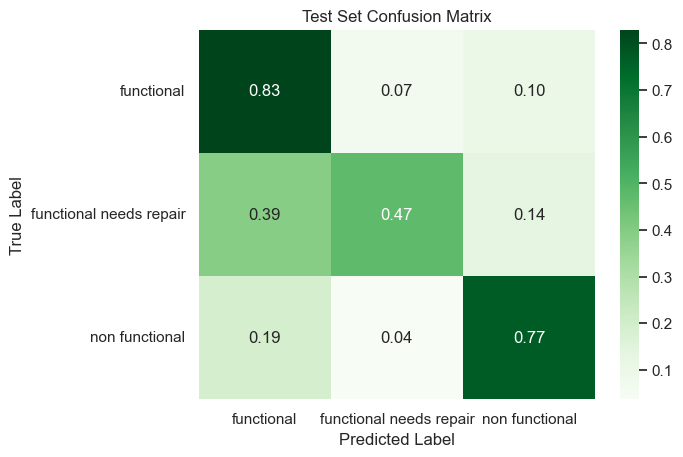

In [48]:
cm = confusion_matrix(y_test_encoded,y_test_pred, normalize="true")
sns.heatmap(cm, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            annot=True, fmt=".2f", cmap="Greens")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Test Set Confusion Matrix")

77% of the non functional states were detected by the model which allow to signicantly avoid pumps failures. Face to states where the pump is functional but needs repair, the model is less efficient with only 47% from these states were truly predicted.

In [49]:
# display feature importances depending on the mean decrease in impurity
data = list(zip(xgboost.feature_names_in_, xgboost.feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
df_importances

,Feature,Importance
126,cat_transformer__quantity_dry,0.184563
27,cat_transformer__region_Iringa,0.133671
53,cat_transformer__region_code_17,0.048788
100,cat_transformer__extraction_type_other,0.020784
95,cat_transformer__extraction_type_gravity,0.020218
...,...,...
45,cat_transformer__region_code_1,0.000000
51,cat_transformer__region_code_15,0.000000
48,cat_transformer__region_code_12,0.000000
46,cat_transformer__region_code_10,0.000000


The "quantity" and "region" features have significant importance for the model.